In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [2]:
df=pd.read_csv('FinalData.csv')
# df.head(22)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1906500 entries, 0 to 1906499
Columns: 129 entries, CH1 to Label
dtypes: float64(129)
memory usage: 1.8 GB


In [3]:
N_TIME_STEPS = 250
N_FEATURES = 128 #128
step = 250 # 20
segments = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    ch = []
    for j in range(0, N_FEATURES):
        ch.append(df.iloc[:, j].values[i: i + N_TIME_STEPS])
    segments.append(ch)

In [4]:
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    label = stats.mode(df['Label'][i: i + N_TIME_STEPS])[0][0]
    labels.append(label)
labelsl = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [5]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labelsl, test_size=0.3, random_state=RANDOM_SEED)

In [6]:
N_CLASSES = 2
N_HIDDEN_UNITS = 32

In [7]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [8]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [9]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


In [10]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [12]:
BATCH_SIZE = 256
N_EPOCHS = 50  # 50

file_info = [N_HIDDEN_UNITS, BATCH_SIZE, N_EPOCHS]
dumps_dir = "nhid-{}_bat-{}_nepoc-{}/dumps/".format(*file_info)
logs_dir = "nhid-{}_bat-{}_nepoc-{}/logs/".format(*file_info)

history = pickle.load(open(dumps_dir + 'history.p', "rb"))
predictions = pickle.load(open(dumps_dir + 'predictions.p', "rb"))

In [13]:
ckpt = tf.train.get_checkpoint_state(logs_dir)

saver = tf.train.Saver()

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, logs_dir + "har.ckpt")
    predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss],
                                                  feed_dict={X: X_test, Y: y_test})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from nhid-32_bat-256_nepoc-50/logs/har.ckpt


In [14]:
# pp = [np.argmax(p) for p in predictions]
# print(pp)
#predictions

In [15]:
#np.shape(y_test) #
#reshaped_segments.shape
#np.shape(labels)
#print(int(labels[37370:37500]))
# results = [int(i) for i in labels[37370:37500]]
# print(results)

In [16]:
print("Model Accuracy: ", acc_final, "Model Loss: ", loss_final)

# predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

Model Accuracy:  0.9777098 Model Loss:  0.14677522


In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(
    y_test.argmax(axis=1), predictions.argmax(axis=1))

array([[1093,   29],
       [  22, 1144]], dtype=int64)

In [18]:
from sklearn.metrics import roc_curve
y_pred_keras = predictions
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test[:,0], y_pred_keras[:,0])

In [19]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

roc_auc_score(y_test, predictions)

0.996939427572058

In [20]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

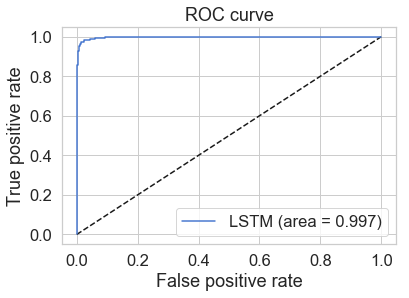

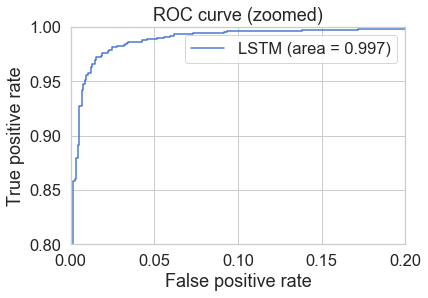

In [21]:
# https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed)')
plt.legend(loc='best')
plt.show()